In [92]:
from astropy.table import Table
from astropy.io import fits
from astropy import units as u

import os

import matplotlib
import matplotlib.pyplot as plt

from scipy.integrate import trapezoid

import numpy as np
import pandas as pd

import tqdm

## Define filter sets

In [2]:
# Top-hat like filter transmission curve
def tophat_trans(x, center=0, fwhm=1, smoothness=0.2):

    from scipy.special import erf, erfc
    
    t_left  = erfc(+((2*(x-center)/fwhm)-1)/smoothness)/2 
    t_right = erfc(-((2*(x-center)/fwhm)+1)/smoothness)/2
    
    return (t_left*t_right)

### original filter sets w/o atmospheric effect

In [5]:
lambda_7ds = np.arange(4000., 9000., 250)
# flux_7ds = np.zeros_like(lambda_7ds)

filters_original = {}

for ii, wl_cen in enumerate(lambda_7ds):
    fwhm = 250
    wave_lvf = np.linspace(0.1, 1.0, 1001)
    resp_lvf = tophat_trans(wave_lvf, center=wl_cen/1e4, fwhm=fwhm/1e4)
    
    filters_original[f'wave_{wl_cen}'] = wave_lvf
    filters_original[f'resp_{wl_cen}'] = resp_lvf
    
#     flux_7ds[ii] = synth_phot(wl, f_nu, wave_lvf, resp_lvf)

# plt.xlim(0.3, 1.0)

In [7]:
# filters_original

### corrected filter sets w/ atmospheric effect & telescope characteristics

#### Detectors
- Assume quantum efficiency (QE) of the Gemini GMOS as an example

Text(0.5, 1.0, 'Gemini GMOS-N Hamamatsu CCD')

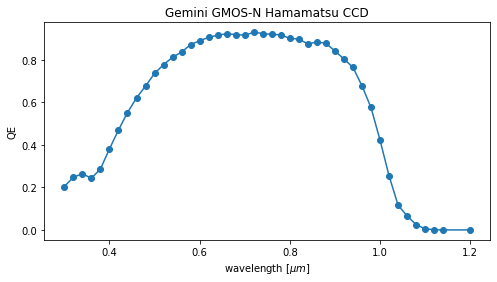

In [9]:
# QE table of Gemini GMOS-N Hamamatsu CCD
T_qe = Table.read('http://www.gemini.edu/sciops/instruments/gmos/gmos_n_ccd_hamamatsu_sc.txt', 
                  format='ascii.no_header', names=('wavelength', 'QE'))
T_qe['wavelength'] = T_qe['wavelength'].astype(float) * 1e-3
T_qe['wavelength'].unit = u.um
T_qe['wavelength'].format = '8.4f'

plt.figure(figsize=(8,4))
plt.plot(T_qe['wavelength'], T_qe['QE'], 'o-')
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('QE')
plt.title('Gemini GMOS-N Hamamatsu CCD')

#### efficiency

In [10]:
eff_mirrors = (0.92)**2  # Aluminium coating, 2 mirrors
eff_optics = 0.95        # Camera optics 
eff_LVF = 0.90           # LVF peak transmission (filter top transmission)
eff_fpa = 0.80           # Detector Quantum Efficiency (QE), nominal value

lambda_mid = 0.6
eff_fpa = np.interp(lambda_mid, T_qe['wavelength']/1000, T_qe['QE'])

eff_opt   = eff_mirrors * eff_optics * eff_LVF
eff_total = eff_opt * eff_fpa

eff_fpa, eff_opt, eff_total

(0.0, 0.723672, 0.0)

### Atmospheric transmission
- Site dependent!
- Model for Paranal site (VLT)
    - https://www.eso.org/sci/software/pipelines/skytools/skycalc
    - Run web-based calculator with 
        - `airmass = 1.3`
        - `PWV` = 2.5mm (very good, not critical in the optical)
        - `$\lambda_{min}$ =  300nm`
        - `$\lambda_{min}$ = 5000nm`
        - `Logarithmic binning` λ/Δλ = 20000 (default; decrease to save time and space)
        - Check `Calculate Broad-Band`

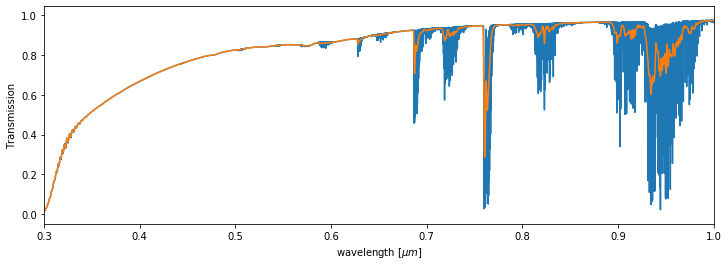

In [17]:
sky_tbl = Table.read('./22A_special_lecture/data/skytable.fits')

plt.figure(figsize=(12,4))
plt.plot(sky_tbl['lam']/1e3, sky_tbl['trans'])
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Transmission')
plt.xlim(0.3, 1)

from scipy.ndimage import gaussian_filter
trans_smooth = gaussian_filter(sky_tbl['trans'], 10)
plt.plot(sky_tbl['lam']/1e3, trans_smooth)

In [19]:
filters_corrected = {}

for ii, wl_cen in enumerate(lambda_7ds):
    
    wave_lvf = filters_original[f'wave_{wl_cen}']
    resp_lvf = filters_original[f'resp_{wl_cen}']
    
    
    resp_sys = resp_lvf.copy()
    intp_qe = np.interp(wave_lvf, T_qe['wavelength'], T_qe['QE'])
    intp_trans = np.interp(wave_lvf, sky_tbl['lam']*1e-3, trans_smooth)
    
    resp_sys = resp_sys * intp_qe * intp_trans 
    resp_sys *= eff_mirrors * eff_optics
    
    filters_corrected[f'resp_{wl_cen}'] = resp_sys
    filters_corrected[f'wave_{wl_cen}'] = wave_lvf
    

In [43]:
colors = plt.cm.Spectral(np.linspace(1, 0, 20))

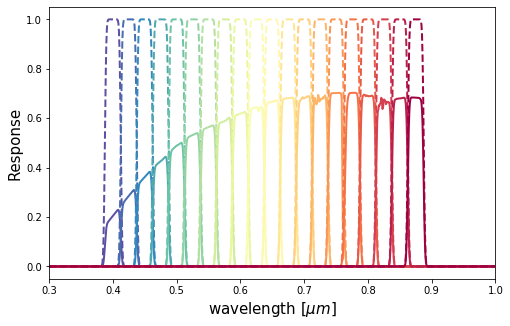

In [195]:
fig, ax = plt.subplots(figsize = (8, 5))

for ii, wl_cen in enumerate(lambda_7ds):
    
    wave_ori = filters_original[f'wave_{wl_cen}']
    resp_ori = filters_original[f'resp_{wl_cen}']
    
        
    wave_cor = filters_corrected[f'wave_{wl_cen}']
    resp_cor = filters_corrected[f'resp_{wl_cen}']
    
    ax.plot(wave_ori, resp_ori, color = colors[ii], linewidth = 2, linestyle = '--')
    ax.plot(wave_cor, resp_cor, color = colors[ii], linewidth = 2)
    
ax.set_xlim(0.3, 1)

ax.set_xlabel('wavelength [$\mu m$]', fontsize = 15)
ax.set_ylabel('Response', fontsize = 15)

fig.savefig('./figs/filter_resp.png')

# Synthetic photometry

In [54]:
# photometry function

def synth_phot(wave, flux, wave_lvf, resp_lvf, tol=1e-3):
    """
    Quick synthetic photometry routine.

    Parameters
    ----------
    wave : `numpy.ndarray`
        wavelength of input spectrum.
    flux : `numpy.ndarray`
        flux density of input spectrum in f_nu unit
    wave_lvf : `numpy.ndarray`
        wavelength of the response function
    resp_lvf : `numpy.ndarray`
        response function. assume that this is a QE.
    tol : float, optional
        Consider only wavelength range above this tolerence (peak * tol).
        The default is 1e-3.

    Returns
    -------
    Astropy.table with [wavelength, f_nu]
        wavelength is the center of the response function

    """
    index_filt, = np.where(resp_lvf > resp_lvf.max()*tol)

    index_flux, = np.where(np.logical_and( wave > wave_lvf[index_filt].min(), 
                                           wave < wave_lvf[index_filt].max() ))

    wave_resamp = np.concatenate( (wave[index_flux], wave_lvf[index_filt]) )
    wave_resamp.sort()
    wave_resamp = np.unique(wave_resamp)
    flux_resamp = np.interp(wave_resamp, wave, flux)
    resp_resamp = np.interp(wave_resamp, wave_lvf, resp_lvf)

    return trapezoid(resp_resamp / wave_resamp * flux_resamp, wave_resamp) \
         / trapezoid(resp_resamp / wave_resamp, wave_resamp)

In [51]:
plates = os.listdir('/data6/SDSSspec')
plates.sort()

plates = plates[:-1]
print(f'total {len(plates)} plates')

total 3809 plates


In [188]:
for pl in tqdm.tqdm(plates[900+364+1420:]):
    
    spec_path = "/data6/SDSSspec/" + pl + "/"
    tbl_path = "/data6/SDSSspec_sup/" + pl + "/"
    
    specphot = pd.read_csv(tbl_path + 'specPhotoAll_' + pl + '.csv')
    
    gal_mask = specphot['class'] == 'GALAXY'
    specphot_gal = specphot[gal_mask]
    
    if len(specphot_gal) == 0:
        continue
    
    plate_fluxes = []
    
    for idx in range(len(specphot_gal)):
        
        cand = specphot_gal.iloc[idx]
        
        mjd = cand['mjd']
        fiberid = cand['fiberID']
        
#         spec = Table.read(spec_path + 'spec-'+ pl + f'-{mjd:d}-' + f'{fiberid:04d}.fits')
        spec = fits.open(spec_path + 'spec-'+ pl + f'-{mjd:d}-' + f'{fiberid:04d}.fits', ignore_missing_end=True)    
        spec = Table(spec[1].data)
    
        wl = 10**spec['loglam'] # Anstrom
        f_lambda = spec['flux'] * 1e-17 # erg/s/cm2/A

        f_nu = f_lambda * wl * (wl / 2.99792e18) / (1e-23 * 1e-6)  # micro Jansky
        wl = wl / 10000      # micron
        
        #synthetic photometry
        lambda_7ds = np.arange(4000., 9000., 250)
        flux_7ds = np.zeros_like(lambda_7ds, dtype = float)
        
        for ii, wl_cen in enumerate(lambda_7ds):
            
            wave_lvf = filters_corrected[f'wave_{wl_cen}']
            resp_lvf = filters_corrected[f'resp_{wl_cen}']
            
            flux_7ds[ii] = synth_phot(wl, f_nu, wave_lvf, resp_lvf)
        
        plate_fluxes.append(flux_7ds)
        
    
    plate_fluxes = np.array(plate_fluxes)
    
    # create table
    cols = []
    cols.append(np.array([int(pl)] * len(specphot_gal))) #plate
    cols.append(specphot[gal_mask]['mjd'].values) #mjd
    cols.append(specphot[gal_mask]['fiberID'].values) #fiberID
    
    names = ['plate', 'mjd', 'fiberid']
    for ii, wl_cen in enumerate(lambda_7ds):
        cols.append(plate_fluxes[:, ii])
        names.append(f'flux_{int(wl_cen):d}')
        
    tbl_synphot = Table(cols, names = names)
    tbl_synphot.write(tbl_path + 'synphot.csv', overwrite = True)




  0%|          | 0/1125 [00:00<?, ?it/s]


  0%|          | 2/1125 [00:00<01:18, 14.27it/s]


  0%|          | 4/1125 [00:00<01:20, 13.93it/s]


  0%|          | 5/1125 [00:03<21:21,  1.14s/it]


  1%|          | 6/1125 [00:04<16:42,  1.12it/s]


  1%|          | 7/1125 [00:06<23:15,  1.25s/it]


  1%|          | 9/1125 [00:10<28:09,  1.51s/it]


  1%|          | 10/1125 [00:16<53:13,  2.86s/it]


  1%|          | 11/1125 [00:22<1:10:58,  3.82s/it]


  1%|          | 12/1125 [00:29<1:25:58,  4.63s/it]


  1%|          | 13/1125 [00:36<1:39:32,  5.37s/it]


  1%|          | 14/1125 [00:42<1:42:08,  5.52s/it]


  1%|▏         | 15/1125 [00:49<1:52:10,  6.06s/it]


  1%|▏         | 16/1125 [00:56<1:57:49,  6.37s/it]


  2%|▏         | 17/1125 [01:03<1:59:08,  6.45s/it]


  2%|▏         | 18/1125 [01:10<2:03:54,  6.72s/it]


  2%|▏         | 19/1125 [01:16<2:01:29,  6.59s/it]


  2%|▏         | 20/1125 [01:23<1:59:59,  6.52s/it]


  2%|▏         | 21/1125 [01:29<1:57:08,  6.37s/it]


  

 12%|█▏        | 135/1125 [13:55<2:10:26,  7.91s/it]


 12%|█▏        | 136/1125 [14:04<2:16:24,  8.28s/it]


 12%|█▏        | 137/1125 [14:12<2:14:56,  8.20s/it]


 12%|█▏        | 138/1125 [14:12<1:36:34,  5.87s/it]


 12%|█▏        | 139/1125 [14:13<1:09:35,  4.24s/it]


 12%|█▏        | 140/1125 [14:13<50:52,  3.10s/it]  


 13%|█▎        | 141/1125 [14:14<37:53,  2.31s/it]


 13%|█▎        | 143/1125 [14:14<26:56,  1.65s/it]


 13%|█▎        | 145/1125 [14:14<19:06,  1.17s/it]


 13%|█▎        | 146/1125 [14:20<42:10,  2.58s/it]


 13%|█▎        | 147/1125 [14:27<1:04:33,  3.96s/it]


 13%|█▎        | 148/1125 [14:34<1:18:06,  4.80s/it]


 13%|█▎        | 149/1125 [14:41<1:29:30,  5.50s/it]


 13%|█▎        | 150/1125 [14:48<1:35:46,  5.89s/it]


 13%|█▎        | 151/1125 [14:53<1:33:01,  5.73s/it]


 14%|█▎        | 152/1125 [15:01<1:42:46,  6.34s/it]


 14%|█▎        | 153/1125 [15:08<1:46:40,  6.59s/it]


 14%|█▎        | 154/1125 [15:14<1:43:42,  6.41s/it]


 14%|█▍        | 1

 24%|██▎       | 265/1125 [26:03<1:28:33,  6.18s/it]


 24%|██▎       | 266/1125 [26:10<1:30:59,  6.36s/it]


 24%|██▎       | 267/1125 [26:16<1:30:23,  6.32s/it]


 24%|██▍       | 268/1125 [26:22<1:28:30,  6.20s/it]


 24%|██▍       | 269/1125 [26:29<1:30:31,  6.34s/it]


 24%|██▍       | 270/1125 [26:35<1:30:29,  6.35s/it]


 24%|██▍       | 271/1125 [26:41<1:28:53,  6.25s/it]


 24%|██▍       | 272/1125 [26:47<1:25:57,  6.05s/it]


 24%|██▍       | 273/1125 [26:52<1:24:08,  5.93s/it]


 24%|██▍       | 274/1125 [26:55<1:10:31,  4.97s/it]


 24%|██▍       | 275/1125 [27:01<1:12:36,  5.13s/it]


 25%|██▍       | 276/1125 [27:07<1:18:28,  5.55s/it]


 25%|██▍       | 277/1125 [27:13<1:21:54,  5.79s/it]


 25%|██▍       | 278/1125 [27:20<1:22:48,  5.87s/it]


 25%|██▍       | 279/1125 [27:24<1:19:00,  5.60s/it]


 25%|██▍       | 280/1125 [27:31<1:23:12,  5.91s/it]


 25%|██▍       | 281/1125 [27:36<1:20:50,  5.75s/it]


 25%|██▌       | 282/1125 [27:43<1:25:14,  6.07s/it]


 25%|██▌  

 35%|███▍      | 393/1125 [37:57<1:11:21,  5.85s/it]


 35%|███▌      | 394/1125 [38:04<1:12:51,  5.98s/it]


 35%|███▌      | 395/1125 [38:10<1:14:03,  6.09s/it]


 35%|███▌      | 396/1125 [38:16<1:14:12,  6.11s/it]


 35%|███▌      | 397/1125 [38:22<1:14:28,  6.14s/it]


 35%|███▌      | 398/1125 [38:29<1:14:22,  6.14s/it]


 35%|███▌      | 399/1125 [38:34<1:11:48,  5.94s/it]


 36%|███▌      | 400/1125 [38:41<1:13:59,  6.12s/it]


 36%|███▌      | 401/1125 [38:47<1:13:59,  6.13s/it]


 36%|███▌      | 402/1125 [38:53<1:15:40,  6.28s/it]


 36%|███▌      | 403/1125 [38:59<1:12:54,  6.06s/it]


 36%|███▌      | 404/1125 [39:04<1:11:04,  5.92s/it]


 36%|███▌      | 405/1125 [39:10<1:08:58,  5.75s/it]


 36%|███▌      | 406/1125 [39:16<1:11:08,  5.94s/it]


 36%|███▌      | 407/1125 [39:22<1:10:38,  5.90s/it]


 36%|███▋      | 408/1125 [39:27<1:08:56,  5.77s/it]


 36%|███▋      | 409/1125 [39:33<1:09:08,  5.79s/it]


 36%|███▋      | 410/1125 [39:39<1:08:00,  5.71s/it]


 37%|███▋ 

 46%|████▋     | 521/1125 [50:49<1:03:59,  6.36s/it]


 46%|████▋     | 522/1125 [50:55<1:02:53,  6.26s/it]


 46%|████▋     | 523/1125 [51:02<1:02:28,  6.23s/it]


 47%|████▋     | 524/1125 [51:07<1:01:10,  6.11s/it]


 47%|████▋     | 525/1125 [51:15<1:04:24,  6.44s/it]


 47%|████▋     | 526/1125 [51:21<1:04:25,  6.45s/it]


 47%|████▋     | 527/1125 [51:28<1:05:01,  6.52s/it]


 47%|████▋     | 528/1125 [51:34<1:04:44,  6.51s/it]


 47%|████▋     | 529/1125 [51:41<1:06:28,  6.69s/it]


 47%|████▋     | 530/1125 [51:48<1:06:18,  6.69s/it]


 47%|████▋     | 531/1125 [51:53<1:02:03,  6.27s/it]


 47%|████▋     | 532/1125 [51:57<54:15,  5.49s/it]  


 47%|████▋     | 533/1125 [52:02<52:14,  5.30s/it]


 47%|████▋     | 534/1125 [52:06<48:40,  4.94s/it]


 48%|████▊     | 535/1125 [52:11<50:13,  5.11s/it]


 48%|████▊     | 536/1125 [52:16<49:47,  5.07s/it]


 48%|████▊     | 537/1125 [52:23<55:11,  5.63s/it]


 48%|████▊     | 538/1125 [52:29<56:23,  5.76s/it]


 48%|████▊     | 539/1

 58%|█████▊    | 651/1125 [1:03:49<44:05,  5.58s/it]


 58%|█████▊    | 652/1125 [1:03:55<44:39,  5.67s/it]


 58%|█████▊    | 653/1125 [1:04:01<45:34,  5.79s/it]


 58%|█████▊    | 654/1125 [1:04:07<45:49,  5.84s/it]


 58%|█████▊    | 655/1125 [1:04:13<46:07,  5.89s/it]


 58%|█████▊    | 656/1125 [1:04:18<45:22,  5.81s/it]


 58%|█████▊    | 657/1125 [1:04:24<45:36,  5.85s/it]


 58%|█████▊    | 658/1125 [1:04:30<45:14,  5.81s/it]


 59%|█████▊    | 659/1125 [1:04:35<43:19,  5.58s/it]


 59%|█████▊    | 660/1125 [1:04:41<43:10,  5.57s/it]


 59%|█████▉    | 661/1125 [1:04:46<42:08,  5.45s/it]


 59%|█████▉    | 662/1125 [1:04:52<42:28,  5.50s/it]


 59%|█████▉    | 663/1125 [1:04:57<42:32,  5.52s/it]


 59%|█████▉    | 664/1125 [1:05:03<42:49,  5.57s/it]


 59%|█████▉    | 665/1125 [1:05:09<43:01,  5.61s/it]


 59%|█████▉    | 666/1125 [1:05:14<43:26,  5.68s/it]


 59%|█████▉    | 667/1125 [1:05:20<44:18,  5.80s/it]


 59%|█████▉    | 668/1125 [1:05:26<43:44,  5.74s/it]


 59%|█████

 69%|██████▉   | 779/1125 [1:16:12<34:25,  5.97s/it]


 69%|██████▉   | 780/1125 [1:16:18<34:00,  5.92s/it]


 69%|██████▉   | 781/1125 [1:16:24<34:30,  6.02s/it]


 70%|██████▉   | 782/1125 [1:16:30<34:20,  6.01s/it]


 70%|██████▉   | 783/1125 [1:16:36<33:13,  5.83s/it]


 70%|██████▉   | 784/1125 [1:16:42<34:02,  5.99s/it]


 70%|██████▉   | 785/1125 [1:16:48<34:02,  6.01s/it]


 70%|██████▉   | 786/1125 [1:16:54<33:10,  5.87s/it]


 70%|██████▉   | 787/1125 [1:16:59<32:02,  5.69s/it]


 70%|███████   | 788/1125 [1:17:05<31:50,  5.67s/it]


 70%|███████   | 789/1125 [1:17:10<31:32,  5.63s/it]


 70%|███████   | 790/1125 [1:17:16<31:38,  5.67s/it]


 70%|███████   | 791/1125 [1:17:23<33:07,  5.95s/it]


 70%|███████   | 792/1125 [1:17:28<32:13,  5.81s/it]


 70%|███████   | 793/1125 [1:17:34<32:32,  5.88s/it]


 71%|███████   | 794/1125 [1:17:40<32:38,  5.92s/it]


 71%|███████   | 795/1125 [1:17:46<32:11,  5.85s/it]


 71%|███████   | 796/1125 [1:17:51<31:15,  5.70s/it]


 71%|█████

 81%|████████  | 907/1125 [1:31:04<34:16,  9.43s/it]


 81%|████████  | 908/1125 [1:31:13<33:40,  9.31s/it]


 81%|████████  | 909/1125 [1:31:23<33:41,  9.36s/it]


 81%|████████  | 910/1125 [1:31:31<32:45,  9.14s/it]


 81%|████████  | 911/1125 [1:31:39<31:33,  8.85s/it]


 81%|████████  | 912/1125 [1:31:47<30:10,  8.50s/it]


 81%|████████  | 913/1125 [1:31:56<30:24,  8.61s/it]


 81%|████████  | 914/1125 [1:32:05<30:20,  8.63s/it]


 81%|████████▏ | 915/1125 [1:32:14<30:27,  8.70s/it]


 81%|████████▏ | 916/1125 [1:32:21<29:23,  8.44s/it]


 82%|████████▏ | 917/1125 [1:32:31<30:13,  8.72s/it]


 82%|████████▏ | 918/1125 [1:32:40<30:28,  8.83s/it]


 82%|████████▏ | 919/1125 [1:32:50<31:21,  9.13s/it]


 82%|████████▏ | 920/1125 [1:32:59<31:34,  9.24s/it]


 82%|████████▏ | 921/1125 [1:33:08<31:27,  9.25s/it]


 82%|████████▏ | 922/1125 [1:33:18<31:25,  9.29s/it]


 82%|████████▏ | 923/1125 [1:33:28<31:57,  9.49s/it]


 82%|████████▏ | 924/1125 [1:33:37<31:37,  9.44s/it]


 82%|█████

 92%|█████████▏| 1034/1125 [1:49:48<14:17,  9.42s/it]


 92%|█████████▏| 1035/1125 [1:49:56<13:40,  9.12s/it]


 92%|█████████▏| 1036/1125 [1:50:06<13:38,  9.19s/it]


 92%|█████████▏| 1037/1125 [1:50:16<13:55,  9.50s/it]


 92%|█████████▏| 1038/1125 [1:50:25<13:38,  9.41s/it]


 92%|█████████▏| 1039/1125 [1:50:34<13:24,  9.35s/it]


 92%|█████████▏| 1040/1125 [1:50:44<13:18,  9.39s/it]


 93%|█████████▎| 1041/1125 [1:50:53<13:09,  9.40s/it]


 93%|█████████▎| 1042/1125 [1:51:02<12:44,  9.21s/it]


 93%|█████████▎| 1043/1125 [1:51:11<12:34,  9.20s/it]


 93%|█████████▎| 1044/1125 [1:51:20<12:11,  9.04s/it]


 93%|█████████▎| 1045/1125 [1:51:29<12:10,  9.13s/it]


 93%|█████████▎| 1046/1125 [1:51:38<11:54,  9.04s/it]


 93%|█████████▎| 1047/1125 [1:51:47<11:47,  9.07s/it]


 93%|█████████▎| 1048/1125 [1:51:57<12:00,  9.35s/it]


 93%|█████████▎| 1049/1125 [1:52:06<11:49,  9.34s/it]


 93%|█████████▎| 1050/1125 [1:52:15<11:18,  9.04s/it]


 93%|█████████▎| 1051/1125 [1:52:24<11:10,  9.07

In [189]:
tbl_synphot

plate,mjd,fiberid,flux_4000,flux_4250,flux_4500,flux_4750,flux_5000,flux_5250,flux_5500,flux_5750,flux_6000,flux_6250,flux_6500,flux_6750,flux_7000,flux_7250,flux_7500,flux_7750,flux_8000,flux_8250,flux_8500,flux_8750
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9632,58130,2,1.9918769514036156,1.6769119369720775,1.417687491927886,1.9807084729663895,2.10238347847033,2.1196924464146636,2.4178364237445984,2.252263070351444,2.1671266889988474,2.2708685506876214,2.4180698230076105,2.24943295417384,4.421637044444091,3.8788143008284046,3.510961507098808,2.7892261818433908,3.1018074654413006,4.4433834573617315,2.490324024532107,-0.019361260174791416
9632,58130,3,1.5228842759836607,1.4770394956270085,1.7426679863651187,1.9363452194999562,2.5944662469388398,2.485434063506506,5.012038308662287,2.7539527593926585,2.8280523343058745,2.4751563743404676,2.96522914385205,3.438130183883171,4.862238648675717,5.251012870013812,5.239090776187926,3.761281589317632,3.577151497042262,5.893695035710706,5.459391376616113,6.715469626897545
9632,58130,5,1.6262736418503505,1.1426800271934603,1.844168346066884,2.390185388682183,2.8233252223262593,3.163636761392553,2.5418608232017093,3.3590314435027406,3.2320351102602856,5.421694181388989,3.717073953178501,4.806884680551738,6.287496293329863,6.879406499640205,8.644252392155087,6.773880993236863,6.968079589642485,7.380635611359029,10.867945450995254,8.012425754305884
9632,58130,6,2.133306189865179,2.021344958834669,1.8671998015633897,2.3015718556486795,3.3865282779578982,3.231096177219988,2.9977245122193956,3.9566432356158967,3.579925854853074,4.646640388345577,4.094493412284376,5.0072561713824975,5.0461641142368485,5.541325137296908,6.901740391891675,6.932086150157667,6.61286424787421,9.837552328669984,8.975026345668022,6.8235620219138955
9632,58130,8,1.615062730159841,1.6499053213909074,1.5991234639348595,1.7329733863670251,2.3242148716062414,2.368251127532439,1.5925778231095256,2.4451537265691106,1.8157460495047624,2.2912885036077024,2.970128638044117,4.24407514530645,4.7825522706755,5.217510296103522,5.6047966405035226,5.953925132336292,7.267190603001264,7.2690227271359635,8.894004284365392,6.71864445858171
9632,58130,10,2.1048213092183454,1.2336538692155052,1.6483233234368178,1.9126362259831553,1.811898226219926,1.7048162053290903,0.3767499577894483,2.1139556326246702,1.6865622058870864,2.4184376748562286,1.9669366827207262,1.8911141013822814,3.673673105047001,4.431148382794479,5.314603592070359,4.280842037259404,2.5203047577991424,5.495997896492268,3.2784696999346514,0.5354921257584546
9632,58130,11,2.9178687253272257,3.2409910929055843,2.941188753980782,2.6922880126797093,2.982627314040503,2.571933769359062,2.3831650089134007,3.3043205320714084,3.355883695240804,3.3324375197960157,3.01028851359045,4.4843204281751365,3.616959975731327,3.8388498211064657,3.453339987270936,2.473721173518154,3.2083590851777117,2.7943901634400152,5.207526914257751,3.773857658071695
9632,58130,17,2.4070879631129865,2.5394136111132406,2.295136811939054,2.0475801529917192,2.1379837606889525,2.079474161080121,1.847217799372446,2.2057690139483945,2.5428168145895738,2.4388203487744513,2.70155586683079,2.2929705074536955,4.224938064863709,4.098095441478266,3.7791232242976225,2.8983024539883613,4.413796032405965,4.146976902731818,4.247255413652264,3.776463742050989
9632,58130,18,1.742316821490528,1.9315561846985545,2.0244730500320243,3.1291274058523855,3.0486809615713244,3.1872132238471154,3.668515793947394,4.548134029074914,4.5715620553268685,5.007719728239077,6.233702562778886,7.460918593848591,9.372064126293468,11.89124677415885,10.621374971287375,12.08780923090718,14.95581337795879,14.932713008658876,16.206503108482593,15.25039536964146


(array([  1.,   1.,   0.,  23., 104., 275., 175.,  63.,  12.,   2.]),
 array([20.36611846, 20.74793575, 21.12975304, 21.51157032, 21.89338761,
        22.2752049 , 22.65702219, 23.03883948, 23.42065677, 23.80247405,
        24.18429134]),
 <a list of 10 Patch objects>)

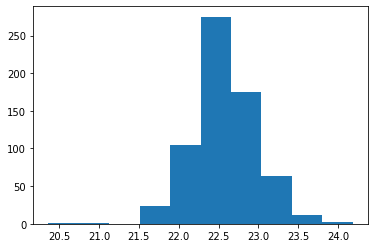

In [193]:
plt.hist(-2.5 * np.log10(tbl_synphot['flux_6000'][tbl_synphot['flux_6000'] > 0] * 1e-6 * 1e-23) - 48.6)

In [124]:
f'flux_{int(wl_cen):d}'

'flux_4000'

In [107]:
# cand
specphot_gal.iloc[2]
# cand

specObjID     11259001129156237312
mjd                          58141
plate                        10000
tile                         16204
fiberID                          7
                      ...         
dered_r                    21.8251
dered_i                      20.62
dered_z                    19.6454
mjd_my                       58141
fiberid_my                       7
Name: 6, Length: 124, dtype: object

In [ ]:
spec = Table.read(spec_path + 'spec-'+ pl + f'-{mjd:d}-' + f'{fiberid:04d}.fits')

In [83]:
specphot[gal_mask]

,specObjID,mjd,plate,tile,fiberID,z,zErr,class,subClass,zWarning,...,extinction_i,extinction_z,fieldID,dered_u,dered_g,dered_r,dered_i,dered_z,mjd_my,fiberid_my
0,11258999485274281984,58462,10000,16204,1,0.606742,0.000219,GALAXY,NaN,0,...,0.095427,0.070980,1237680250561298432,24.28170,22.77911,21.30207,20.24133,19.44386,58462,1
3,11259000572270106624,57716,10000,16204,5,0.681351,0.000269,GALAXY,NaN,0,...,0.113744,0.084604,1237680250024493056,22.64131,22.77679,21.68160,20.58113,19.82677,57716,5
6,11259001129156237312,58141,10000,16204,7,0.834163,0.000332,GALAXY,NaN,0,...,0.095224,0.070829,1237680284389605376,22.33740,23.79659,21.82507,20.61998,19.64539,58141,7
13,11259004982832420864,58462,10000,16204,21,0.630744,0.000174,GALAXY,NaN,0,...,0.110419,0.082131,1237680250024427520,23.42980,22.48353,21.21381,20.18416,19.47416,58462,21
18,11259007181855676416,58462,10000,16204,29,0.597831,0.000181,GALAXY,NaN,0,...,0.094895,0.070584,1237680284389539840,23.10976,24.13372,21.49819,20.30204,19.55387,58462,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,11259264180182865920,57716,10000,16204,964,1.001368,0.000034,GALAXY,NaN,0,...,0.117959,0.087740,1237680251097907200,21.99529,21.63849,21.43376,21.17906,21.58493,57716,964
502,11259267760725972992,58141,10000,16204,977,0.626672,0.000303,GALAXY,NaN,0,...,0.114835,0.085416,1237680251098038272,26.16484,24.38251,21.84466,20.52616,19.87609,58141,977
506,11259270514890528768,58462,10000,16204,987,0.791346,0.000354,GALAXY,NaN,0,...,0.112365,0.083579,1237680285463216128,25.59473,23.76091,21.82335,20.62923,19.83653,58462,987
508,11259271601886353408,57716,10000,16204,991,0.611011,0.000294,GALAXY,NaN,0,...,0.115002,0.085541,1237680285463281664,23.53044,24.10798,21.30738,20.19014,19.48421,57716,991


(array([19., 12., 24., 85., 34.,  3.,  3.,  0.,  3.,  1.]),
 array([-7.56316600e-04,  1.96118615e-01,  3.92993547e-01,  5.89868478e-01,
         7.86743410e-01,  9.83618342e-01,  1.18049327e+00,  1.37736821e+00,
         1.57424314e+00,  1.77111807e+00,  1.96799300e+00]),
 <a list of 10 Patch objects>)

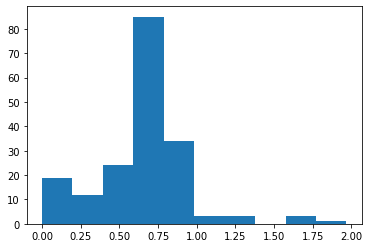

In [66]:
plt.hist(specphot[gal_mask]['z'])

How to calculate flux-uncertainty from photometry? ([ref](https://wise2.ipac.caltech.edu/staff/fmasci/ApPhotUncert.pdf))

- $1-\sigma$ uncertainty (square roote of noise variance)
- assumption: no severe pixel-to-pixel correlations

$\sigma^{2}_{src} = \frac{1}{g}\sum_{i}^{N_{A}}\frac{(S_{i} - \bar{B})}{N_{i}} + (N_{A} + k\frac{N^{2}_{A}}{N_{B}})\times \sigma^{2}_{B/pix}$

- $g$: gain in electrons/pixel data units
- $N_{A}$: number of pixels in source aperture
- $N_{B}$: number of pixels in background annulus
- $N_{i}$: depth of coverage at pixel i
- $S_{i}$: signal in pixel in i in image data units
